### In this notebook we go through the process of training our model

We'll start by loading our data and encoding our categorical variables,  
since in our EDA process we saw that our data contains many unique values,  
it's best to use binary encoding over one-hot encoding

In addition to this, after some experimentation I've come to the conclusion  
that having the data in it's current form is not beneficial, I'll have to transform  
it back to the form of Artist : text, Genres: text[], so we will have to put in  
a form known as the transactional format

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

ag_df = pd.read_csv('data/ag_data.csv')
ag_df.head()

,Artist,Subgenre
0,Jason Mraz,acoustic pop
1,Jason Mraz,dance pop
2,Jason Mraz,neo mellow
3,Jason Mraz,pop
4,The Paper Kites,acoustic pop


In [7]:
ag_df2 = ag_df[~(ag_df['Subgenre'].str.contains('sleep'))].copy()

transactional_data = ag_df2.groupby('Artist')['Subgenre'].agg(list).reset_index()
transactional_data.head()

,Artist,Subgenre
0,!!!,"[alternative dance, dance rock, dance-punk, el..."
1,!T.O.O.H.!,[technical grindcore]
2,"""14""",[swedish rock-and-roll]
3,"""Cats"" 1981 Original London Cast",[show tunes]
4,"""DEMONS""","[action rock, punk 'n' roll, swedish garage rock]"


In [8]:
transactional_data['Subgenre'] = transactional_data['Subgenre'].astype('string') 

In [9]:
transactional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34962 entries, 0 to 34961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Artist    34962 non-null  object
 1   Subgenre  34962 non-null  string
dtypes: object(1), string(1)
memory usage: 546.4+ KB


In [5]:
transactional_data.to_csv('data/transactional_data.csv',index=False)

Let's now use Binary Encoding on the subgenre column and create our training set

In [10]:
encoder = ce.BinaryEncoder(cols=['Subgenre'])

data_enc = encoder.fit_transform(transactional_data['Subgenre'])

data_enc.shape

(34962, 14)

Now that our data is preprocessed we can begin with training our model,   
we're going to opt for K-Modes since we're dealing with categorical data,  
to choose the optimal amount of clusters we'll take a look at the elbow method

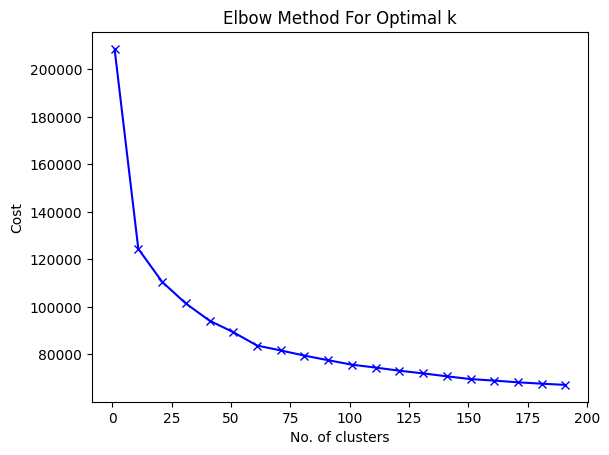

In [151]:
from kmodes.kmodes import KModes

cost = []
K = range(1,200,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters)
    kmode.fit_predict(data_enc,n_init=5,init='Huang')
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

We'll opt for 75 as our number of clusters

In [ ]:
from kmodes.kmodes import KModes

km = KModes(n_clusters=75, init='Huang', n_init=5)
clusters = km.fit_predict(data_enc)

for i in range(75):
    artists = transactional_data[clusters == i]['Artist'].tolist()
    print(f"Cluster {i+1}: {artists}")

Let's now create a helper function that'll fetch us artists corresponding to genres of interest,  
we'll save this as a utility function

In [135]:
def recommend_artists(genre_lst,model,encoder,data,rec_count):
    
    genre_df = pd.DataFrame({'Subgenre':[genre_lst]})
    genre_df['Subgenre'] = genre_df['Subgenre'].astype('string')
    genre_enc = encoder.transform(genre_df['Subgenre'])

    user_cluster = model.predict(genre_enc)
    user_recommendations = data[model.labels_ == user_cluster]['Artist'].to_numpy()
    idx = np.random.randint(0,len(user_recommendations),rec_count)
    return user_recommendations[idx]

In [149]:
print(recommend_artists(['EDM','Trance'],km,encoder,transactional_data,10))

['Marburg' 'Carvis Turney' 'Taarka' "'Til Tuesday" 'Emrah Turken'
 '10-FEET' 'Rose Royce' 'Angel Olsen' 'The Diamonds' 'Igneous Flame']


# Project Update

After playing around with the project and interpretting the results, I've come to the conclusion that  
in order for more appropriate recommendations to be given, there would have to be an increase in the amount 
of clusters in the model  

To determine the optimal amount of clusters I'll take a look at the silhoutte scores 

In [ ]:
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

scores = []

for k in range(50,750,50):
    km = KModes(n_clusters=k, init='Huang', n_init=5)
    km.fit_predict(data_enc)
    scores.append(silhouette_score(data_enc,km.labels_))

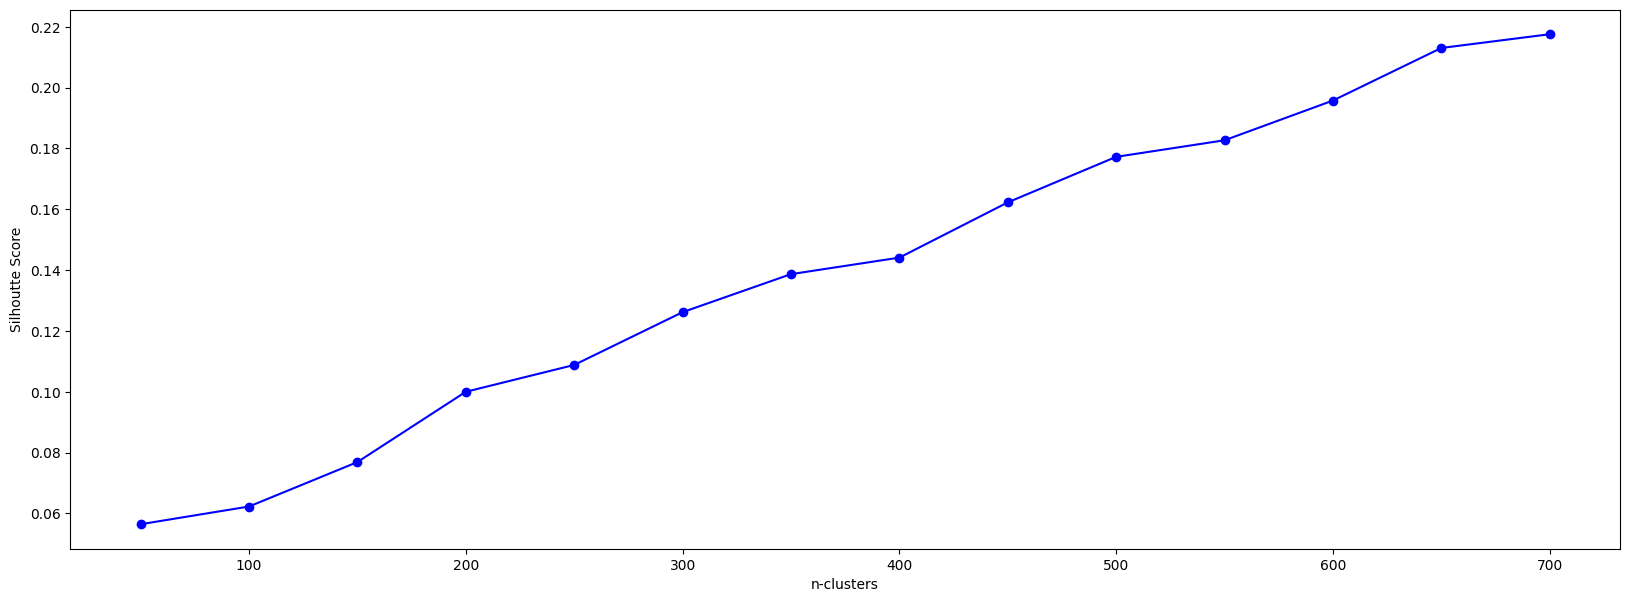

In [19]:
plt.figure(figsize=(20,7))
plt.plot(range(50,750,50),scores,'bo-')
plt.xlabel('n-clusters')
plt.ylabel('Silhoutte Score')
plt.show()

The score is continuing to rise so lets keep inreasing the number of clusters and analyze  
where the silhoutte score peaks

In [20]:
km = KModes(n_clusters=700, init='Huang', n_init=5)
km.fit_predict(data_enc)

array([342, 619, 414, ...,  30, 406, 575], dtype=uint16)

Let's save our model and encoder

In [21]:
import joblib

joblib.dump(value = [km,encoder], filename='models/model.pkl')

['models/model.pkl']